<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

Let's load the iris dataset first

In [5]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

data = load_iris()
X, y = data.data, data.target
X_trn, X_val, y_trn, y_val = train_test_split(X, y, random_state=42)

... and create the data loaders

In [1]:
from torch_snippets.markup2 import AD
from torch.utils.data import TensorDataset

trn_ds = TensorDataset(*[torch.Tensor(i) for i in [X_trn, y_trn]])
trn_dl = DataLoader(trn_ds, batch_size=32)

val_ds = TensorDataset(*[torch.Tensor(i) for i in [X_val, y_val]])
val_dl = DataLoader(val_ds, batch_size=32)

AD(next(iter(val_dl)))


```↯ AttrDict ↯
next(iter(val_dl))[]
  0 - 🔦tensor[32, 4] n=128 x∈[0.100, 7.900] μ=3.488 σ=2.034 - ID:#56f55949
  1 - 🔦tensor[32] x∈[0., 2.000] μ=0.969 σ=0.861 - ID:#b365fa0a

```

Next we'll import Capsule and a few decorators that will tell the model to change it's mode to train/test during the `fit` function

```python
from torch_snippets.trainer.capsule import Capsule, train, validate, predict
```

Create the neural network and define it's forward function as usual pytorch business. Only difference now is that you'll also add `self.loss_fn` and `self.optimizer` attributes in the init

```python
class IrisModel(Capsule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.BatchNorm1d(4),
            nn.Linear(4, 16),
            nn.Dropout(0.2),
            nn.BatchNorm1d(16),
            nn.ReLU(inplace=True),
            nn.Linear(16, 8),
            nn.Dropout(0.2),
            nn.BatchNorm1d(8),
            nn.ReLU(inplace=True),
            nn.Linear(8, 3),
        )
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters())

    def forward(self, x):
        return self.model(x)
```

To fully describe the model's behaviour we still need to define three functions  
1. `train_batch`  
2. `validate_batch` and,  
3. `predict` which is optional  

like so

```python

    @train
    def train_batch(self, batch):
        x, y = batch
        _y = self.forward(x)
        loss = self.loss_fn(_y, y.long())
        return {"loss": loss}

    @validate
    def validate_batch(self, batch=None, dl=None):
        if dl is not None:
            output = []
            for batch in dl:
                output.extend(self.predict(batch=batch)["val_acc"])
            return np.mean(output)
        x, y = batch
        _y = self.forward(x)
        loss = self.loss_fn(_y, y.long())
        acc = (y == _y.max(-1)[1]).float().mean()
        return {"val_loss": loss, "val_acc": acc}

    @predict
    def predict(self, batch=None, dl=None):
        if dl is not None:
            output = []
            for batch in dl:
                output.extend(self.predict(batch=batch))
            return output
        x, y = batch
        _y = self.forward(x)
        o = _y.max(-1)[1].cpu().detach().numpy().tolist()
        return o
```

* Ensure you return dictionaries of losses, accuracy metrics in `train_batch` and `validate_batch` functions. You can return as many metrics during training and validation, they will be auto logged.  
* Also make sure at least one of the keys in `train_batch` is the key **loss**, as this is used to compute gradients.* 

We could now create the model...

In [8]:
model = IrisModel()
model.device = "cpu"

... and run `model.fit` with an optional number of logs to print to the console

EPOCH: 1.000  val_acc: 0.281  loss: 1.118  val_loss: 1.159  (0.05s - 5.02s remaining)
EPOCH: 50.000  val_acc: 1.000  loss: 0.490  val_loss: 0.406  (0.18s - 0.18s remaining)
EPOCH: 100.000  val_acc: 1.000  loss: 0.238  val_loss: 0.162  (0.31s - 0.00s remaining)


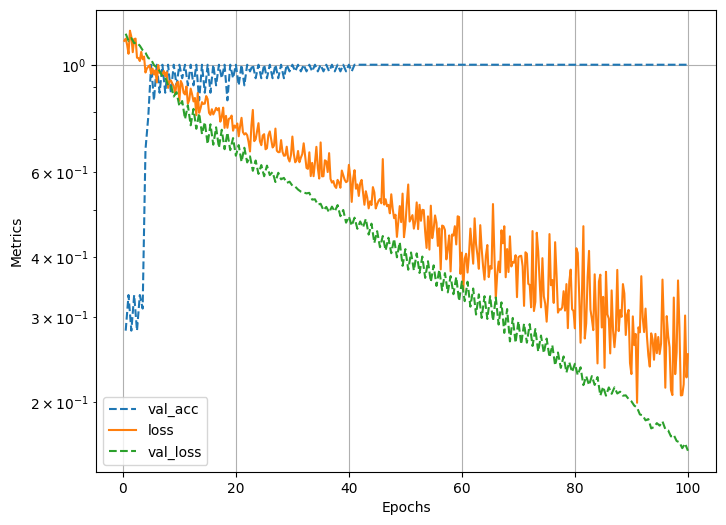

In [9]:
model.fit(trn_dl, val_dl, num_epochs=100, print_total=2, device="cpu")

`model.evaluate` accepts a validation data loader that will repeatedly call `validate_batch` and return aggregated metrics

In [10]:
model.evaluate(val_dl, device="cpu")

EPOCH: 1.000  val_acc: 1.000  val_loss: 0.164  (0.00s - 0.00s remaining)


{'epoch_val_acc': np.float64(1.0),
 'epoch_val_loss': np.float64(0.16414348781108856)}